In [1]:
!pip install colormath
!pip install colormap
!pip install easydev
!pip install webcolors
!pip install PIL

  Stored in directory: C:\Users\suraj.sawant\AppData\Local\pip\Cache\wheels\20\49\7b\9635bccd6136cc713f623caa85ced89c0c63878f8b2a58fe99
Successfully built colormath


Algorithm for image dissection: 

1. get the list of all possible standard colors including white and black
2. a. Build dictionary that has key as standard color and values is the list of all nearest color in image exist.
3. Now for all above list :
   1. *get the percent of rgb count out of total image rgb's.
   2. Make dictionary (img_prime_rgb_dict) of key as most common rgb in list and values as list of rest of rgbs. 
   3. Make list (imp_prime_rgb) of those keys with its pix percent in respective segment, which has pix percent more than         3%.
4. get exceptional rgbs list (exceptional_rgbs) that has more than 3% pixels but not included into imp_prime_rgb.
5. For all exceptional rgbs:
   1. include these exceptional rgbs as keys in img_prime_rgb_dict.
   2. Append the rgbs into 5th step keys from the rgbs involve in its closest existing key based on lower distance.
6. final_prime_rgbs will be included both imp_prime_rgb and exceptional_rgbs.
7. In img_prime_rgb_dict, dictionary key's list diluted to closest final_prime_rgbs as key's list .
8. Now, this way, imp_prime_dict is builded. this dictinary will help to replace color in image.

In [122]:
def image_describe(im):
    import webcolors as wc
    import numpy as np
    from webcolors import rgb_to_name
    from colormap import rgb2hex
    from collections import Counter
    def get_approx_color(hex_color):
            orig = wc.hex_to_rgb(hex_color)
            similarity = {}
            for hex_code, color_name in wc.css3_hex_to_names.items():
                approx = wc.hex_to_rgb(hex_code)
                similarity[color_name] = sum(np.subtract(orig, approx) ** 2)
            return min(similarity, key=similarity.get)

    def get_color_name(hex_color):
        try:
            return wc.hex_to_name(hex_color)
        except ValueError:
            return get_approx_color(hex_color)
    def distance(c1, c2):
        (r1,g1,b1) = c1
        (r2,g2,b2) = c2
        return int((r1-r2)**2+(g1-g2)**2+(b1-b2)**2)

    # Here, get the rgb combination for standard 17 color names 
    from itertools import permutations 
    rgb_sets = [[255,255,255],[0,125,255],[0,255,255],[0,0,255],[125,255,255],[0,0,0]]
    prime_std_rgb= []
    for rgb in rgb_sets:
        prime_std_rgb.extend(list(set(permutations(rgb, 3))))

    import webcolors as wc
    import numpy as np
    from webcolors import rgb_to_name
    from colormap import rgb2hex
    from collections import Counter
    def get_approx_color(hex_color):
            orig = wc.hex_to_rgb(hex_color)
            similarity = {}
            for hex_code, color_name in wc.css3_hex_to_names.items():
                approx = wc.hex_to_rgb(hex_code)
                similarity[color_name] = sum(np.subtract(orig, approx) ** 2)
            return min(similarity, key=similarity.get)

    def get_color_name(hex_color):
        try:
            return wc.hex_to_name(hex_color)
        except ValueError:
            return get_approx_color(hex_color)
    def distance(c1, c2):
        (r1,g1,b1) = c1
        (r2,g2,b2) = c2
        return int(math.sqrt((r1-r2)**2+(g1-g2)**2+(b1-b2)**2))
    # convert image into array values of (r,g,b) in float type
    data = np.array(im)
    data = data.astype(np.float64)
    arr_lst_rgb = data.reshape((data.shape[0] * data.shape[1]), data.shape[2])  # convert 2D matrix into 1D matrix of [r,g,b]
    arr_tupl_rgb = [tuple(rgb) for rgb in arr_lst_rgb] 
    pixel_count = len(arr_tupl_rgb)
    prime_img_rgb = [rgb for rgb,pix in Counter(arr_tupl_rgb).most_common() if round((pix/pixel_count)*100,2)>3]

    from collections import defaultdict
    prime_dict_img_rgb = defaultdict(list)
    for rgb1 in arr_tupl_rgb:
        closest_rgbs = [distance(rgb, rgb1) for rgb in prime_std_rgb]        
        closest_rgb = prime_std_rgb[np.argsort(closest_rgbs)[0]]
        prime_dict_img_rgb[closest_rgb].append(rgb1)
    prime_dict_img_rgb = dict(prime_dict_img_rgb)

    img_prime_rgb_dict = {}
    imp_prime_rgb_pix = []
    for key, value in prime_dict_img_rgb.items(): 
            pixCent = round(((len(value)/pixel_count)*100),2)
            sort_value= Counter(value).most_common()
            img_prime_rgb_dict[sort_value[0][0]] = [x[0] for x in sort_value[1:]]
            if (pixCent>3):
                imp_prime_rgb_pix.append((sort_value[0][0],pixCent))

    imp_prime_rgb = [rgb for rgb,pix in imp_prime_rgb_pix]
    exceptional_rgbs =[rgb for rgb in prime_img_rgb if rgb not in imp_prime_rgb]
    final_prime_rgbs = imp_prime_rgb + exceptional_rgbs
    
    for rgb1 in exceptional_rgbs:
        closest_rgbs = [distance(rgb, rgb1) for rgb in imp_prime_rgb]        
        closest_rgb = imp_prime_rgb[np.argsort(closest_rgbs)[0]]
        closest_rgb_list = [rgb for rgb in img_prime_rgb_dict[closest_rgb] if distance(rgb,closest_rgb)<distance(rgb,rgb1)]
        rgb1_list = [rgb for rgb in img_prime_rgb_dict[closest_rgb] if rgb not in closest_rgb_list]
        del img_prime_rgb_dict[closest_rgb]
        img_prime_rgb_dict[closest_rgb] = closest_rgb_list
        img_prime_rgb_dict[rgb1] = rgb1_list    

    from collections import defaultdict
    imp_prime_dict = defaultdict(list)
    for key, value in img_prime_rgb_dict.items():
        closest_rgbs = [distance(rgb, key) for rgb in final_prime_rgbs]        
        closest_rgb = final_prime_rgbs[np.argsort(closest_rgbs)[0]]
        imp_prime_dict[closest_rgb].extend(value)
    imp_prime_dict = dict(imp_prime_dict)
    final_prime_rgb_pix = [(rgb,(pix/pixel_count)*100) for rgb,pix in Counter(arr_tupl_rgb).most_common() if rgb in final_prime_rgbs]
    colorList = [get_color_name(rgb2hex(int(rgb[0]), int(rgb[1]), int(rgb[2]))) for rgb,_ in final_prime_rgb_pix]
    
    max_color_len = len(max(colorList, key=len))
    rgb_pix_col = [final_prime_rgb_pix[i] + (k,) for i, k in enumerate(colorList)]
    print("\033[1mColor\033[0m" + " " * (
            max_color_len - 5) + " (R  , G  , B  )" + " \033[1mHexCode\033[0m" + " \033[1mPercentage\033[0m")
    for rgb, pixel, col in rgb_pix_col:                   
        rgb = tuple(map(int,rgb))
        r,g,b = rgb
        hexVal = rgb2hex(r, g, b)
        print("{0}".format(col) + " " * (max_color_len - len(col) + 1) + str(rgb) + " " * (15 - (len(str(rgb))) + 1) +
              "{0}".format(hexVal) + "  {:.2f}% ".format(pixel))
    
    return imp_prime_dict

In [112]:
# path = 'C:/Users/suraj.sawant/Downloads/marco-promos-logo-tagline.jpg'
path = 'C:/Users/suraj.sawant/Downloads/big-cnbc-2013-01-27.jpg'
# path = 'C:/Users/suraj.sawant/Downloads/Wahkiakum.png'
img_name = [name for name in path.split('/')][-1]

import numpy as np
from PIL import Image,ImageFilter

im = Image.open(path)
%pylab inline
imgplot = plt.imshow(im)
plt.show()

Now, image_describe() function makes return of dictionary which has key as dominat color rgb and value as nearest color group which is not detectable by human eyes. This function also displays color name, RGB value, HexCode, and its percenatage.

In [123]:
dominant_rgb = image_describe(im)

Color         (R  , G  , B  ) HexCode Percentage
white         (255, 255, 255) #FFFFFF  41.55% 
black         (10, 11, 13)    #0A0B0D  8.32% 
forestgreen   (0, 161, 58)    #00A13A  5.02% 
darkslateblue (92, 79, 148)   #5C4F94  4.88% 
darkcyan      (0, 112, 182)   #0070B6  4.85% 
orange        (245, 173, 0)   #F5AD00  4.84% 
brown         (186, 35, 66)   #BA2342  4.82% 
chocolate     (227, 102, 18)  #E36612  4.61% 


In [48]:
def new_image(dominant_rgb,img):
    newim2 = img.convert('RGB')
    data_new = np.array(newim2)
    red, green, blue = data_new[:,:,0], data_new[:,:,1], data_new[:,:,2]
    for key, values in dominant_rgb.items():
        r2,g2,b2 = map(int,key)
        for rgb in [tuple(map(int,rgb)) for rgb in values]:
            (r1,g1,b1) = rgb
            mask = (red == r1) & (green == g1) & (blue == b1)
            data_new[:,:,:3][mask] = [r2, g2, b2]    
    img = Image.fromarray(np.uint8(data_new))
    
#     img = img.filter(ImageFilter.SMOOTH)
#     img = img.filter(ImageFilter.MinFilter)
#     img = img.filter(ImageFilter.MedianFilter)
#     img = img.filter(ImageFilter.MedianFilter)
#     img = img.filter(ImageFilter.SMOOTH)
#     img = img.filter(ImageFilter.EDGE_ENHANCE)
    return img

In [49]:
new_img = new_image(dominant_rgb,im)

In [91]:
orange = (245,173,0)
orng = (246, 155, 23)
goldenrod = (254, 149, 42)
brown = (186,35,66)
chocolate = (227,102,18)
green = (0,255,0)
lightseagreen =(0, 162, 177)
black = (10,11,13)

Here, we are simply replace color and return the effective image named as replace_image

In [ ]:
def replace_color(img, replace_list, origin,replace):        
    newim2 = img.convert('RGB')
    data = np.array(newim2)
    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2] # Temporarily unpack the bands for readability
    r2,g2,b2 = replace
    for sec_rgb in [tuple(map(int,rgb)) for rgb in replace_list]:
        (r1,g1,b1) = sec_rgb
        mask = (red == r1) & (green == g1) & (blue == b1)
        data[:,:,:3][mask] = [r2, g2, b2]
    r1,g1,b1 = origin
    mask = (red == r1) & (green == g1) & (blue == b1)
    data[:,:,:3][mask] = [r2, g2, b2]    
    im2 = Image.fromarray(data)
    return im2

In [118]:
# origin,replace =(0, 162, 177), green
origin,replace =(10, 11, 13), green
# origin,replace =(0, 162, 177), green
replace_image = replace_color(im,dominant_rgb[origin],origin,replace)

Here, we are making use of two basic type filter based on 

In [89]:
def distantEdges(img,times=1):
    from PIL import ImageFilter
    for i in range(times):
        img = img.filter(ImageFilter.SMOOTH)
        img = img.filter(ImageFilter.MedianFilter)
    return img

def closeEdges(img,times=1):
    from PIL import ImageFilter
    for i in range(times):
        img = img.filter(ImageFilter.SMOOTH_MORE)
    img = img.filter(ImageFilter.EDGE_ENHANCE)
    return img

Populating the interactive namespace from numpy and matplotlib


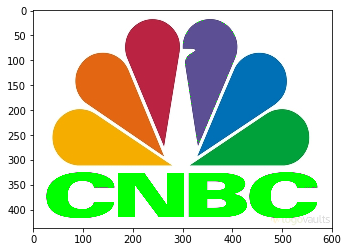

In [119]:
%pylab inline
imgplot = plt.imshow(replace_image)
plt.show()

If you look at above image, at border color replacement is not ok. we need further process to make it fine. for this based on image nature we made two fiters which makes image more beautiful and fine.

In [116]:
img1 = distantEdges(replace_image,2)
img2 = closeEdges(replace_image,2)

Populating the interactive namespace from numpy and matplotlib


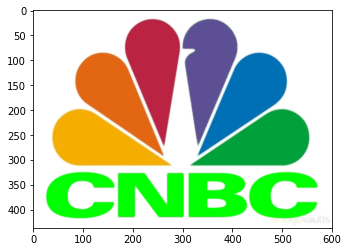

In [117]:
%pylab inline
imgplot = plt.imshow(img1)
plt.show()

Populating the interactive namespace from numpy and matplotlib


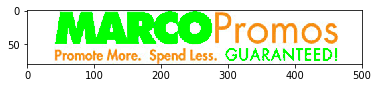

In [111]:
%pylab inline
imgplot = plt.imshow(img2)
plt.show()